# GitOps Flow with MLRun

In [2]:
# !pip install s3fs

## Setup Project

In [1]:
import os
import json

from src import create_and_set_project
from config import AppConfig
from dotenv import load_dotenv

load_dotenv("secrets.env")

config = AppConfig()

project = create_and_set_project(
    name=config.project_name,
    source=config.archive_source,
    secrets_file=config.secrets_file,
    artifact_path=config.artifact_path,
    default_image="nschenone/mlrun-cicd:1.5.0",
    force_build=True
)

> 2024-05-31 20:06:44,828 [info] Project loaded successfully: {'project_name': 'cicd-flow'}
> 2024-05-31 20:06:45,062 [warning] Overwriting artifact old db_key 'model' with new key 'model' - artifact can be fetched using the new key only
Exporting project as zip archive to v3io:///bigdata/cicd-flow.zip...


## Run Training Pipeline

In [2]:
train_config = config.get_workflow_config(workflow_name="train")

In [3]:
project.notifiers.add_notification(notification_type="slack", params={"webhook": os.getenv("SLACK_WEBHOOK_URL")})

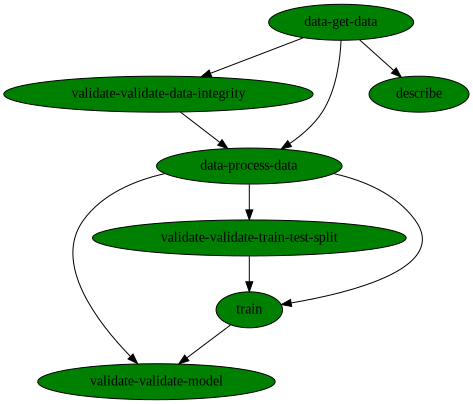

uid,start,state,name,parameters,results
...e05db6f2,May 31 20:11:31,completed,validate-validate-model,model_path=store://artifacts/cicd-flow/model@e08475a6-4c32-423f-9ed5-cca8b4930f52label_column=targetallow_validation_failure=True,passed_suite=False
...ea02751d,May 31 20:10:37,completed,train,label_column=target,best_iteration=1accuracy=0.8771929824561403f1_score=0.8771929824561403precision_score=0.8333333333333334recall_score=0.9259259259259259
...d34f49c1,May 31 20:10:04,completed,validate-validate-train-test-split,label_column=targetallow_validation_failure=True,passed_suite=False
...ef6d9446,May 31 20:09:35,completed,data-process-data,"label_column=targettest_size=0.2ohe_columns=['sex', 'cp', 'slope', 'thal', 'restecg']",
...0fea6d52,May 31 20:08:36,completed,validate-validate-data-integrity,label_column=targetallow_validation_failure=True,passed_suite=True
...d38a8e0b,May 31 20:08:35,completed,describe,label_column=target,
...e04faf93,May 31 20:08:00,completed,data-get-data,,


In [4]:
run_id = project.run(
    name="train",
    arguments=train_config,
    dirty=True,
    watch=True
)

## Run Deployment Pipeline

In [5]:
deploy_config = config.get_workflow_config(workflow_name="deploy")

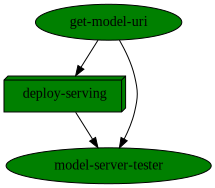

uid,start,state,name,parameters,results
...ec827129,May 31 20:25:19,completed,model-server-tester,addr=http://cicd-flow-serving.default-tenant.app.cst-355.iguazio-cd1.com/label_column=targetmodel=model,total_tests=20errors=0match=8avg_latency=161881min_latency=136802max_latency=206613
...1764ae05,May 31 20:15:18,completed,get-model-uri,model_name=modelmodel_tag=challenger,model_uri=store://models/cicd-flow/model#0:challengertest_set_uri=s3://iguazio-demo/projects/cicd-flow/artifacts/5215e9af-19dd-43ee-9e67-5e0d5d31477e/train/1/test_set.parquet


In [6]:
run_id = project.run(
    name="deploy",
    arguments=deploy_config,
    dirty=True,
    watch=True
)

### Invoke Model

In [7]:
# Get serving function
serving_fn = project.get_function("serving")
model_name = config.deploy_model_name
label_column = config.label_column

# Get test set
df = project.get_artifact("data-process-data_test").to_dataitem().as_df()
display(df.head())

# Transform to list
# Get training set as list
data = df.drop(label_column, axis=1).to_dict(orient="split")["data"]

,sex_female,sex_male,cp_asymtomatic,cp_atypical_angina,cp_non_anginal_pain,cp_typical_angina,slope_downsloping,slope_flat,slope_upsloping,thal_fixed_defect,...,restecg_st-t_wave_abnormality,age,exang,fbs,trestbps,chol,thalach,oldpeak,ca,target
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,54.0,1.0,0.0,122.0,286.0,116.0,3.2,2.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,58.0,1.0,0.0,128.0,216.0,131.0,2.2,3.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,54.0,0.0,0.0,150.0,232.0,165.0,1.6,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,60.0,1.0,0.0,130.0,206.0,132.0,2.4,2.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,62.0,0.0,0.0,124.0,209.0,163.0,0.0,0.0,1.0


In [8]:
serving_fn.invoke(
    f"v2/models/{model_name}/infer", json.dumps({"inputs": data[:5]})
)

> 2024-05-31 20:26:54,681 [info] Invoking function: {'method': 'POST', 'path': 'http://nuclio-cicd-flow-serving.default-tenant.svc.cluster.local:8080/v2/models/model/infer'}


{'id': '67c6ba2e-02a2-4ef9-a1b4-d134b3036081',
 'model_name': 'model',
 'outputs': [0.0, 0.0, 1.0, 0.0, 1.0]}

### Simulate Traffic

MLRun real-time drift detection requires 10,000 events

In [9]:
import json
import logging
from random import choice

from tqdm.notebook import tqdm

# Suppress print messages
logging.getLogger(name="mlrun").setLevel(logging.WARNING)

# Simulate traffic using random elements from training set
for i in tqdm(range(10)):
    data_point = choice(data)
    resp = serving_fn.invoke(
        f"v2/models/{model_name}/infer", json.dumps({"inputs": [data_point]})
    )
    print(resp)

# Resume normal logging
logging.getLogger(name="mlrun").setLevel(logging.INFO)

  0%|          | 0/10 [00:00<?, ?it/s]

{'id': '15a6c801-67d2-4add-9cb8-464d4bf22734', 'model_name': 'model', 'outputs': [1.0]}
{'id': 'bcac0f00-7a7e-46d1-9675-9ab35998155a', 'model_name': 'model', 'outputs': [0.0]}
{'id': 'ce81a613-3951-4dc9-8f15-8d58a5020959', 'model_name': 'model', 'outputs': [0.0]}
{'id': '8be9b862-9456-45b7-8f41-71d3ed9dd785', 'model_name': 'model', 'outputs': [0.0]}
{'id': 'eab51574-32bf-4f42-963b-e5642d4fba43', 'model_name': 'model', 'outputs': [1.0]}
{'id': 'acdc687e-6915-42aa-bef0-878bfe875bf8', 'model_name': 'model', 'outputs': [1.0]}
{'id': 'ea7f769d-87d4-448b-a692-4b3eeb94f10a', 'model_name': 'model', 'outputs': [0.0]}
{'id': '8b02f614-eae0-4f35-ac2a-75405a414c11', 'model_name': 'model', 'outputs': [1.0]}
{'id': 'dfb311e3-838d-4f67-b96f-aae2d0f6e01c', 'model_name': 'model', 'outputs': [1.0]}
{'id': 'd0d26c20-0d85-4b83-ba4a-bc55cf6b40d8', 'model_name': 'model', 'outputs': [1.0]}
